<a href="https://colab.research.google.com/github/chornamarta/ml3.0/blob/main/Module%202/Linear%20Regression/2_%D0%9B%D1%96%D0%BD%D1%96%D0%B8%CC%86%D0%BD%D0%B0_%D1%80%D0%B5%D0%B3%D1%80%D0%B5%D1%81%D1%96%D1%8F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Постановка задачі

Компанія ACME Insurance Inc. пропонує доступне медичне страхування тисячам клієнтів по всіх Сполучених Штатах. Як головний дата-сайєнтіст в ACME, **вам доручено створити автоматизовану систему для оцінки річних медичних зборів для нових клієнтів**, використовуючи інформацію, таку як їх вік, стать, ІМТ ([індекс маси тіла](https://en.wikipedia.org/wiki/Body_mass_index)), наявність дітей, звички щодо куріння та регіон проживання.

Оцінки з вашої системи будуть використовуватися для визначення річної страхової плати (сума, що сплачується щомісяця) пропонованої клієнту. Через регулятивні вимоги, ви повинні мати змогу пояснити, чому ваша система видає певний прогноз.

Вам надано CSV файл `medical-charges.csv`, що містить перевірені історичні дані, які складаються з вищезгаданої інформації та фактичних медичних зборів, здійснених понад 1300 клієнтами.

<img src="https://i.imgur.com/87Uw0aG.png" width="480">

Джерело набору даних: https://github.com/stedy/Machine-Learning-with-R-datasets


## Завантаження даних

Для початку, давайте завантажимо дані.

In [18]:
import pandas as pd
import numpy as np

In [2]:
medical_df = pd.read_csv('medical-charges.csv')

In [3]:
medical_df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


Набір даних містить 1338 рядків та 7 стовпців. Кожен рядок набору даних містить інформацію про одного клієнта.

Наша мета - знайти спосіб оцінки значення в стовпці "charges", використовуючи значення в інших стовпцях. Якщо ми можемо це зробити для історичних даних, то ми повинні змогти оцінити вартість для нових клієнтів, просто запитавши інформацію, таку як їх вік, стать, ІМТ, кількість дітей, звички щодо куріння та регіон.

Давайте перевіримо тип даних для кожного стовпця.

In [4]:
medical_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


Схоже, що "вік", "діти", "ІМТ" та "платежі" є числами, тоді як "стать", "курець" та "регіон" є рядками (можливо, категоріями). Жоден з стовпців не містить пропущених значень, що економить нам чимало часу!

Переглянемо статистику для числових стовпців:

In [5]:
medical_df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


<Axes: >

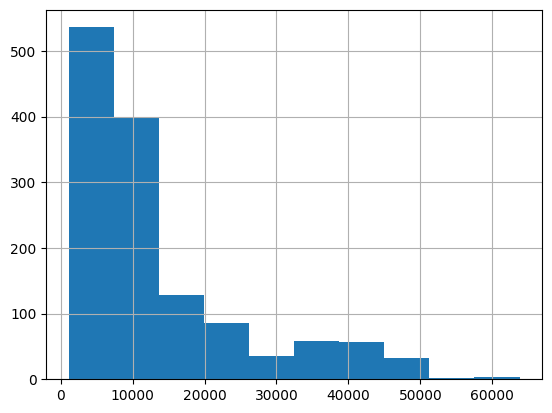

In [6]:
medical_df.charges.hist()

Діапазони значень в числових стовпцях виглядають адекватними (немає від'ємного віку!), тому нам може не довестися робити багато очищення даних або корекції. Однак стовпець "charges" виглядає значно скошеним вліво, оскільки медіана (50 перцентиль) набагато нижча за максимальне значення.

## Дослідницький аналіз та візуалізація

Давайте дослідимо дані, візуалізуючи розподіл значень у деяких стовпцях набору даних, а також взаємозв'язки між "charges" та іншими стовпцями.

In [7]:
!pip install plotly matplotlib seaborn --quiet

In [8]:
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
%matplotlib inline

### Вік

Вік - це числова колонка. Мінімальний вік в наборі даних - 18 років, а максимальний - 64 роки. Таким чином, ми можемо візуалізувати розподіл віку, використовуючи гістограму з 47 бінами (один на кожен рік) та ящик з вусами. Ми використаємо plotly для створення інтерактивної діаграми, але ви можете створити подібні діаграми, використовуючи Seaborn.

In [9]:
medical_df.age.describe()

,age
count,1338.000000
mean,39.207025
std,14.049960
min,18.000000
25%,27.000000
50%,39.000000
75%,51.000000
max,64.000000


In [10]:
? px.histogram

In [11]:
fig = px.histogram(medical_df,
                   x='age',
                   marginal='box',
                   nbins=47,
                   title='Distribution of Age')
fig.update_layout(bargap=0.1)
fig.show()

Розподіл віку в наборі даних майже рівномірний, з 20-30 клієнтами на кожен вік, за винятком 18 та 19 років, де здається, що клієнтів більше ніж у два рази порівняно з іншими віками. Рівномірний розподіл може виникнути через те, що немає великої варіації в [кількості людей певного віку](https://www.statista.com/statistics/241488/population-of-the-us-by-sex-and-age/) (між 18 та 64 роками) в США.

### Індекс маси тіла

Давайте подивимося на розподіл ІМТ (Індексу маси тіла) клієнтів, використовуючи гістограму та ящик з вусами.

In [12]:
fig = px.histogram(medical_df,
                   x='bmi',
                   marginal='box',
                   color_discrete_sequence=['red'],
                   title='Distribution of BMI (Body Mass Index)')
fig.update_layout(bargap=0.1)
fig.show()

In [13]:
medical_df.bmi.describe()

,bmi
count,1338.000000
mean,30.663397
std,6.098187
min,15.960000
25%,26.296250
50%,30.400000
75%,34.693750
max,53.130000


Вимірювання індексу маси тіла, здається, формують [гаусівський розподіл](https://en.wikipedia.org/wiki/Normal_distribution), центрований навколо значення 30, з кількома викидами вправо.

# Про Гаусівський розподіл
Гауссівський розподіл, також відомий як нормальний розподіл, є одним з найважливіших та найчастіше використовуваних розподілів у статистиці. Він має характерну форму дзвону та описує, як розподілені дані навколо середнього значення.

Ключові аспекти про гауссівський розподіл, які усім потрібно знати:

1. **Параметри - середнє значення та стандартне відхилення**: Гауссівський розподіл описується двома параметрами — середнім значенням (μ) та стандартним відхиленням (σ). Середнє значення показує, де на осі значень зосереджені дані, а стандартне відхилення вказує на те, наскільки далеко в середньому дані розподілені від середнього значення.

2. **Симетрія**: Крива нормального розподілу симетрична відносно свого середнього значення. Це означає, що однакова частка даних розташовується з кожного боку від середнього значення.

3. **Розподіл відхилень**: Приблизно 68% усіх значень знаходяться в межах одного стандартного відхилення від середнього, близько 95% — в межах двох стандартних відхилень, а 99.7% — в межах трьох стандартних відхилень. Це відомо як правило 68-95-99.7 або правило трьох сигм.

4. **Широка розповсюдженість**: Нормальний розподіл часто зустрічається в природі та соціальних науках, оскільки багато процесів та характеристик, вивчені в цих сферах, мають тенденцію до нормалізації через вплив багатьох маленьких, незалежних чинників. Наприклад, це можуть бути такі характеристики, як зріст людей, артеріальний тиск, результати тестів тощо.

## Як перевірити, що дані розподілені за Гаусом

Один з поширених способів перевірити, чи дотримується розподіл даних гауссового розподілу - це використання статистичних тестів, найчастіше викорситовують тест Шапіро-Вілка або тест Д'Агостино К^2. Ці тести оцінюють, чи дані мають характеристики нормального розподілу.

- [**Тест Шапіро-Вілка**](https://en.wikipedia.org/wiki/Shapiro%E2%80%93Wilk_test) - ефективний для невеликих вибірок (зазвичай менше 2000 спостережень) і часто використовується для перевірки наявності нормальності.

- [**Тест Д'Агостино К^2**](https://en.wikipedia.org/wiki/D%27Agostino%27s_K-squared_test) - базується на куртозисі та асиметрії ваших даних для перевірки нормальності. Він краще підходить для великих вибірок.

Протестуємо дані BMI на гаусовість:


In [14]:
from scipy.stats import shapiro, normaltest

In [ ]:
? normaltest

In [15]:
data = medical_df['bmi']

# Тест Шапіро-Вілка
stat, p_value_shapiro = shapiro(data)
print("Тест Шапіро-Вілка:")
print("Статистика тесту:", stat)
print("P-значення:", p_value_shapiro)

# Тест Д'Агостино К^2
stat, p_value_agostino = normaltest(data)
print("\nТест Д'Агостино К^2:")
print("Статистика тесту:", stat)
print("P-значення:", p_value_agostino)

# Інтерпретація результатів
if p_value_shapiro > 0.05:
    print("\nЗа результатами тесту Шапіро-Вілка дані мають нормальний розподіл (не відхиляємо H0).")
else:
    print("\nЗа результатами тесту Шапіро-Вілка дані не мають нормального розподілу (відхиляємо H0).")

if p_value_agostino > 0.05:
    print("За результатами тесту Д'Агостино К^2 дані мають нормальний розподіл (не відхиляємо H0).")
else:
    print("За результатами тесту Д'Агостино К^2 дані не мають нормального розподілу (відхиляємо H0).")


Тест Шапіро-Вілка:
Статистика тесту: 0.9938864621676107
P-значення: 2.60468368798344e-05

Тест Д'Агостино К^2:
Статистика тесту: 17.581447872784118
P-значення: 0.0001521377897266011

За результатами тесту Шапіро-Вілка дані не мають нормального розподілу (відхиляємо H0).
За результатами тесту Д'Агостино К^2 дані не мають нормального розподілу (відхиляємо H0).


Іноді може бути корисним протестувати на Гаусовість візуально. Для цього існує метод побудови QQ-графіка (Quantile-Quantile Plot).

# QQ-Plot

QQ-Plot (або квантиль-квантиль графік) взагалі має більш загальне значення — це графічний метод для визначення того, чи відповідає набір даних певному розподілу ймовірностей, чи дві вибірки даних надійшли з однієї сукупності чи ні.

Що собою являє цей графік:
- Це графік квантилів першого набору даних проти **квантилів** другого набору даних.

- Для довідкових цілей також наносять на графік лінію 45%; і якщо вибірки з однієї сукупності, то точки розташовані вздовж цієї лінії.

## Що таке "квантиль"
Не плутати з "квартилем"!

**Квантилі** — це точки в наборі даних, які ділять дані на інтервали, що містять рівні частки загального розподілу (рівну кількість даних на кожен "бін"). Це загальний термін для будь-якого показника, що ділить дані на частини.

Наприклад, **персентиль** є типом квантилю, який ділить розподіл на 100 рівних частин. 25-й персентиль (або перший квартиль) показує, що 25% даних знаходяться нижче цього значення. 50-й персентиль (медіана) ділить дані на дві рівні частини.

**Квартилі** ділять дані на чотири частини, а **децилі** — на десять, де кожен дециль відображає кожні 10% даних.

В цьому методі використовуються саме квантилі і це зручно, адже ми можемо розбити дані на будь-яку кількість частин до кількості точок в даних включно.


## Як намалювати QQ-графік?
Щоб намалювати квантиль-квантильний (QQ) графік на зібраних даних робимо наступні кроки:

1. **Сортування даних**: Впорядковуємо дані за зростанням або спаданням. Цей крок є важливим для точного обчислення квантилів.
2. **Вибір теоретичного розподілу**: Визначаємо теоретичний розподіл, з яким ми хочемо порівняти свій набір даних. Популярні вибори включають нормальний розподіл, експоненціальний розподіл або будь-який інший розподіл, який добре підходить до наших даних.
3. **Обчислення теоретичних квантилів**: Обчислюємо квантилі для обраного теоретичного розподілу. Наприклад, якщо ви порівнюєте з нормальним розподілом, ви б використали зворотну функцію кумулятивного розподілу (CDF) нормального розподілу для визначення очікуваних квантилів.
  - [Про генерацію даних і чому нам треба обернений кумулятивний розподіл в Python](https://towardsdatascience.com/generate-random-variable-using-inverse-transform-method-in-python-8e5392f170a3)
  - для генерації inverse normal CDF використовується метод `ppf(q, loc=0, scale=1)` з [scipy.stats.norm](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html)

4. **Побудова графіка**:
   - Наносимо значення впорядкованого набору даних на вісь x.
   - Наносимо відповідні теоретичні квантилі на вісь y.
   - Кожна точка даних (x, y) представляє пару спостережуваних та очікуваних теоретичних значень.
   - З'єднуємо точки даних, щоб візуально оцінити відносини між набором даних та теоретичним розподілом.


Детальніше про побудову QQ-графіка у цьому [відео](https://youtu.be/okjYjClSjOg?si=N9ISPMnRjbBljtYC).

**Інтерпретація QQ-графіка**
- Якщо точки на графіку приблизно лежать на прямій лінії, це вказує на те, що ваш набір даних відповідає припущеному розподілу.

- Відхилення від прямої лінії вказують на невідповідності з припущеним розподілом, що вимагає подальшого дослідження.

Побудуємо графік для наших даних:

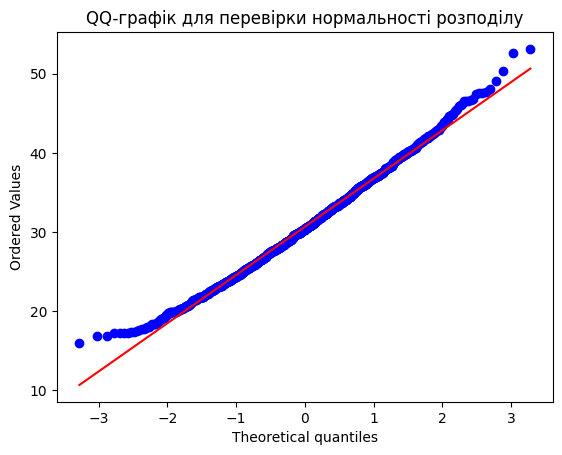

In [16]:
from scipy import stats

stats.probplot(data, dist="norm", plot=plt)
plt.title("QQ-графік для перевірки нормальності розподілу")
plt.show()

## Типи QQ-графіків
Існує кілька типів QQ-графіків, які часто використовуються у статистиці та аналізі даних, кожен з яких підходить для різних сценаріїв чи цілей:

1. **Нормальний розподіл**: Симетричний розподіл, де на QQ-графіку точки приблизно укладаються вздовж діагональної лінії, якщо дані відповідають нормальному розподілу.
2. **Правоскошений розподіл**: Розподіл, на QQ-графіку якого спостерігається візерунок, де спостережувані квантилі відхиляються від прямої лінії вгору, що вказує на довший хвіст з правого боку.
3. **Лівоскошений розподіл**: Розподіл, на QQ-графіку якого спостерігається візерунок, де спостережувані квантилі відхиляються від прямої лінії вниз, що вказує на довший хвіст з лівого боку.
4. **Розподіл із недостатньою дисперсією**: Розподіл, на QQ-графіку якого спостережувані квантилі групуються тісніше навколо діагональної лінії порівняно з теоретичними квантилями, що свідчить про нижчу варіативність.
5. **Розподіл із надмірною дисперсією**: Розподіл, на QQ-графіку якого спостережувані квантилі розподілені ширше або відхиляються від діагональної лінії, що вказує на вищу варіативність або дисперсію порівняно з теоретичним розподілом.

<img src="https://miro.medium.com/v2/resize:fit:846/1*XU3Kdl521XnWHECHZ7XOaQ.jpeg" width="480">

In [19]:
# Генеруємо випадкову вибірку з нормального розподілу
normal_data = np.random.normal(loc=0, scale=1, size=1000)

# Генеруємо випадкову вибірку з право-скошеного розподілу (експоненціальний розподіл)
right_skewed_data = np.random.exponential(scale=1, size=1000)

# Генеруємо випадкову вибірку з ліво-скошеного розподілу (негативний експоненціальний розподіл)
left_skewed_data = -np.random.exponential(scale=1, size=1000)

# Генеруємо випадкову вибірку з розподілу зі зменшеною дисперсією (усічений нормальний розподіл) - менша дисперсія, ніж в звичайному нормальному
under_dispersed_data = np.random.normal(loc=0, scale=0.5, size=1000)
under_dispersed_data = under_dispersed_data[(under_dispersed_data > -1) & (under_dispersed_data < 1)] # Усічення

# Генеруємо випадкову вибірку з розподілу зі збільшеною дисперсією (мікс нормальних) - дисперсія більша за звиклий нормальний
over_dispersed_data = np.concatenate((np.random.normal(loc=-2, scale=1, size=500),
									np.random.normal(loc=2, scale=1, size=500)))

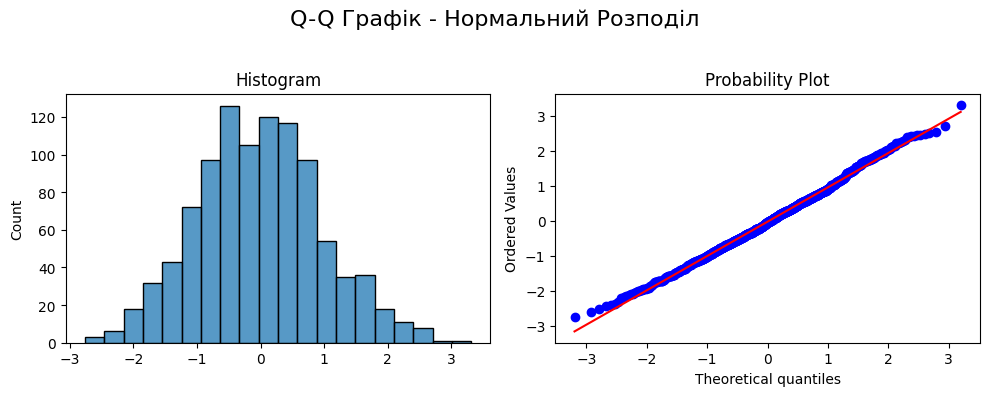

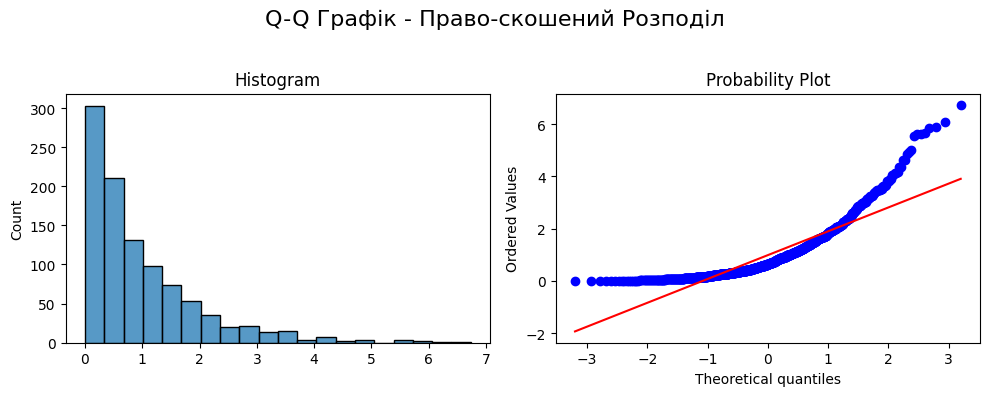

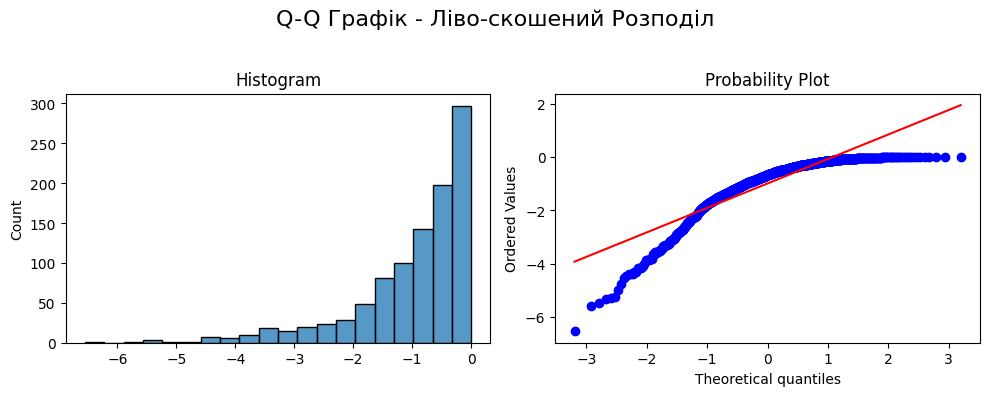

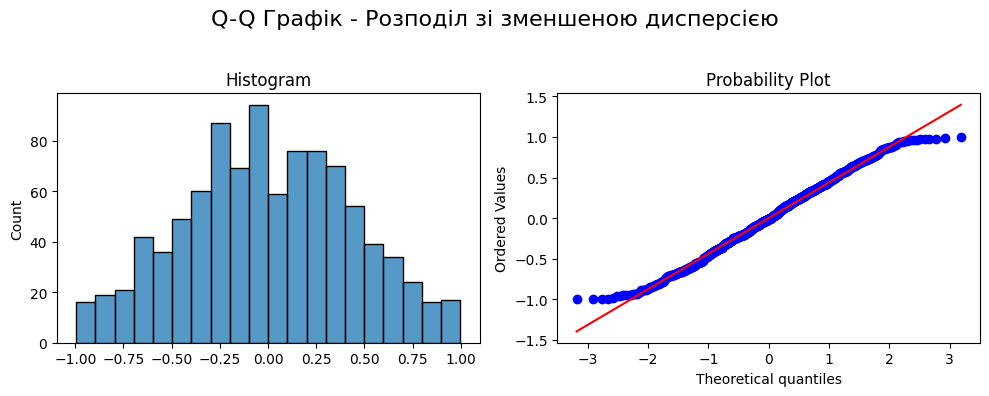

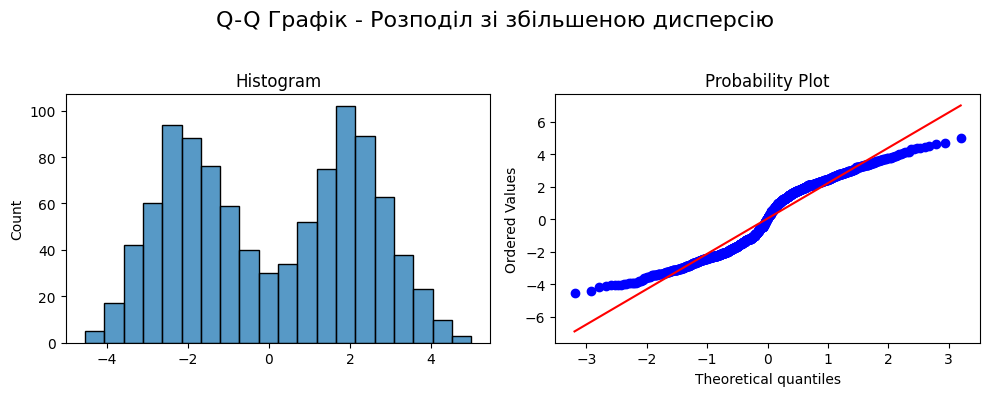

In [20]:
import seaborn as sns

def create_plot(data, title):
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    fig.suptitle(title, fontsize=16)

    sns.histplot(data, bins=20, ax=axs[0])
    axs[0].set_title('Histogram')

    stats.probplot(data, dist="norm", plot=axs[1])
    axs[1].set_title('Probability Plot')

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

create_plot(normal_data, 'Q-Q Графік - Нормальний Розподіл')
create_plot(right_skewed_data, 'Q-Q Графік - Право-скошений Розподіл')
create_plot(left_skewed_data, 'Q-Q Графік - Ліво-скошений Розподіл')
create_plot(under_dispersed_data, 'Q-Q Графік - Розподіл зі зменшеною дисперсією')
create_plot(over_dispersed_data, 'Q-Q Графік - Розподіл зі збільшеною дисперсію')



-----------

# Повернемось до нашої задачі.

Індекс маси тіла (ІМТ) — це спосіб оцінки того, чи є маса тіла людини пропорційною до її зросту. Він розраховується за формулою:

$$ \text{ІМТ} = \frac{\text{маса тіла (кг)}}{\text{зріст (м)}^2} $$

Де маса тіла вказується в кілограмах, а зріст — в метрах. Цей показник дозволяє класифікувати вагу особи та оцінити ризики для здоров'я, що можуть виникнути через недостатню чи надмірну масу тіла.

Ось як можна інтерпретувати значення ІМТ:

![](https://i.imgur.com/lh23OiY.jpg)

Зверніть увагу, вік розподілений рівномірно, а ІМТ - схоже що за законом Гауса, але маємо застосувати тести для перевірки. Рівномірний розподіл віку може бути зумовлений спеціальним формуванням вибірки таким чином для дослідження.

А от ІМТ, який є показником тілесної маси людини відносно її зросту, часто формує нормальний розподіл у населення. Це тому, що ІМТ є результатом складних взаємодій між генетичними, метаболічними, екологічними та культурними чинниками, які зазвичай розподілені серед населення у вигляді bell-curve.

**Центральна гранична теорема** стверджує, що сума великої кількості незалежних випадкових змінних, кожна з яких має власний розподіл, зазвичай наближається до нормального розподілу. Оскільки ІМТ визначається багатьма такими факторами, він має тенденцію до формування нормального розподілу.

**Коротко про ЦГТ**

**Центральна гранична теорема** — це один з ключових принципів статистики, який допомагає нам розуміти, як розподіляються різні дані чи результати спостережень.

Уявімо, що ви кидаєте звичайну монету багато разів і записуєте результати. Кожен кидок можна розглядати як маленький випадковий експеримент, де випадає або "герб", або "решка". Якщо ви кинете монету лише кілька разів, результати можуть сильно відрізнятися (наприклад, всі "герби" або всі "решки"). Але якщо ви кинете монету тисячі разів, співвідношення "гербів" до "решок" буде більш-менш однаковим.

Центральна гранична теорема каже, що якщо ви візьмете багато маленьких випадкових експериментів і додасте їхні результати, то загальний результат (або їх середнє значення) зазвичай матиме форму, яка нагадує дзвіночок, який ми називаємо нормальним розподілом або гауссовим розподілом. Це вірно навіть тоді, коли окремі результати цих експериментів не розподіляються нормально.

Це особливо корисно, тому що дозволяє нам робити припущення про сукупності даних, знаючи лише кілька простих характеристик, як-от середнє значення і стандартне відхилення, і використовувати це для прогнозування ймовірностей та інших статистичних властивостей.


### Збори

Давайте візуалізуємо розподіл "зборів", тобто річних медичних зборів для клієнтів. Це колонка, яку ми намагаємося передбачити. Також використовуймо категоріальну колонку "курець", щоб відрізнити збори для курців та некурців.

In [21]:
fig = px.histogram(medical_df,
                   x='charges',
                   marginal='box',
                   color='smoker',
                   color_discrete_sequence=['green', 'grey'],
                   title='Annual Medical Charges')
fig.update_layout(bargap=0.1)
fig.show()

Ми можемо зробити наступні спостереження з вищенаведеного графіку:

- Для більшості клієнтів річні медичні збори становлять менше \$10,000. Тільки невелика частина клієнтів має вищі медичні збори, можливо, через нещасні випадки, серйозні хвороби та генетичні захворювання. Розподіл слідує ["степеневому закону"](https://uk.wikipedia.org/wiki/%D0%A1%D1%82%D0%B5%D0%BF%D0%B5%D0%BD%D0%B5%D0%B2%D0%B8%D0%B9_%D1%80%D0%BE%D0%B7%D0%BF%D0%BE%D0%B4%D1%96%D0%BB)

- Існує значна різниця в медичних зборах між курцями та некурцями. Тоді як медіана для некурців становить \$7300, медіана для курців наближається до \$35,000.


### Курець чи ні

Давайте візуалізуємо розподіл колонки "курець" (що містить значення "так" та "ні") за допомогою гістограми.

In [22]:
medical_df.smoker.value_counts()

,count
smoker,
no,1064
yes,274


In [23]:
px.histogram(medical_df, x='smoker', color='sex', title='Smoker')

Виглядає, що 20% клієнтів повідомили, що вони курять. Ми також бачимо, що куріння здається більш поширеним серед чоловіків. У випадку роботи з подібними даними ми могли б це додатково перевірити на офіційній статистиці в країні.

Після того, як ми розглянули окремі стовпці, тепер можемо візуалізувати взаємозв'язок між "зборами" (значенням, яке ми хочемо прогнозувати) та іншими стовпцями.

### Вік та збори

Давайте візуалізуємо взаємозв'язок між "віком" та "зборами", використовуючи діаграму розсіювання. Кожна точка на діаграмі розсіювання представляє одного клієнта. Ми також використаємо значення у стовпці "курець" для кольору точок.

In [24]:
fig = px.scatter(medical_df,
                 x='age',
                 y='charges',
                 color='smoker',
                 opacity=0.8,
                 hover_data=['sex'],
                 title='Age vs. Charges')
fig.update_traces(marker_size=5)
fig.show()

Ми можемо зробити наступні висновки з вищенаведеної діаграми:

* Загальна тенденція, здається, полягає в тому, що медичні збори зростають з віком, як ми могли б очікувати. Однак, є значна варіативність на кожному віці, і очевидно, що вік від самого себе не може бути використаний для точного визначення медичних зборів.


* Ми можемо побачити три "кластери" точок, кожен з яких, здається, формує лінію зі зростаючим нахилом:

     1. Перший і найбільший кластер складається, головним чином, з "здорових некурців", які мають відносно низькі медичні збори порівняно з іншими.
     
     2. Другий кластер містить суміш курців і некурців. Можливо, це насправді два різних, але перекриваються кластери: "некурці з медичними проблемами" та "курці без серйозних медичних проблем".
     
     3. Останній кластер складається виключно з курців, очевидно, курців з серйозними медичними проблемами, які, можливо, пов'язані або погіршені курінням.


### Індекс маси тіла та збори

Давайте візуалізуємо відношення між ІМТ (індексом маси тіла) та зборами, використовуючи ще один діаграму розсіювання. Ще раз використаємо значення з колонки "курець" для кольору точок.

In [25]:
fig = px.scatter(medical_df,
                 x='bmi',
                 y='charges',
                 color='smoker',
                 opacity=0.8,
                 hover_data=['sex'],
                 title='BMI vs. Charges')
fig.update_traces(marker_size=5)
fig.show()

Здається, що для некурців збільшення ІМТ не здається пов'язаним зі збільшенням медичних зборів. Однак медичні збори, здається, значно вищі для курців з ІМТ більше 30.

Які інші висновки ви можете зробити з вищенаведеного графіка?

### Кореляція

Переглянемо кореляцію між числовими ознаками.

Щоб обчислити кореляцію для категоріальних стовпців, їх спочатку потрібно перетворити на числові стовпці.

In [26]:
corr = medical_df.select_dtypes(include='number').corr()
corr.style.background_gradient()

,age,bmi,children,charges
age,1.000000,0.109272,0.042469,0.299008
bmi,0.109272,1.000000,0.012759,0.198341
children,0.042469,0.012759,1.000000,0.067998
charges,0.299008,0.198341,0.067998,1.000000


Можемо також візуалізувати так.

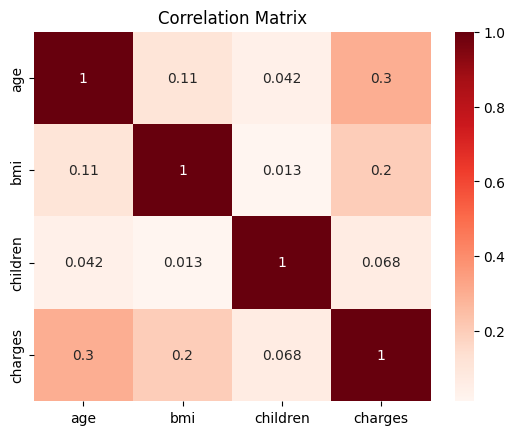

In [27]:
sns.heatmap(corr, cmap='Reds', annot=True)
plt.title('Correlation Matrix');

## Лінійна регресія за допомогою однієї ознаки

### Пригадаємо, що таке "лінія" зі школи

Лінія (або лінійна функія) має наступну формулу:

`y = a*x + b`

У цьому рівнянні, зазвичай, `a` та `b` задані. Це - коефіцієнти.

Почнемо з простого.

`a = 0`
`b = 1`

Отже:

`y = 0*x + 1 = 1`


In [28]:
import numpy as np

xs = np.linspace(0,20,10)

In [29]:
xs

array([ 0.        ,  2.22222222,  4.44444444,  6.66666667,  8.88888889,
       11.11111111, 13.33333333, 15.55555556, 17.77777778, 20.        ])

In [30]:
a = 0
b = 1
y = xs * a + b

In [31]:
y

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

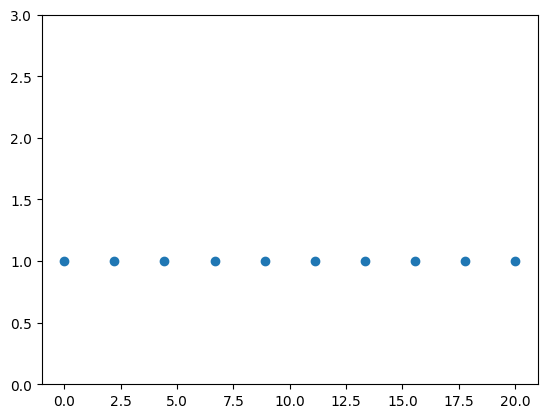

In [32]:
plt.plot(xs , y, 'o')
plt.ylim(ymin=0, ymax=3);

In [33]:
# винесемо в функцію побудову графіка
def build_linear_dependency(a, b):
    xs = np.linspace(0,20,10)
    y = xs * a + b
    print(xs, y)
    plt.plot(xs , y)
    plt.ylim(ymin=0);

Якщо ж `a = 1 b = 1`

Отже:

`y = 1*x + 1 = x + 1`

[ 0.          2.22222222  4.44444444  6.66666667  8.88888889 11.11111111
 13.33333333 15.55555556 17.77777778 20.        ] [ 1.          3.22222222  5.44444444  7.66666667  9.88888889 12.11111111
 14.33333333 16.55555556 18.77777778 21.        ]


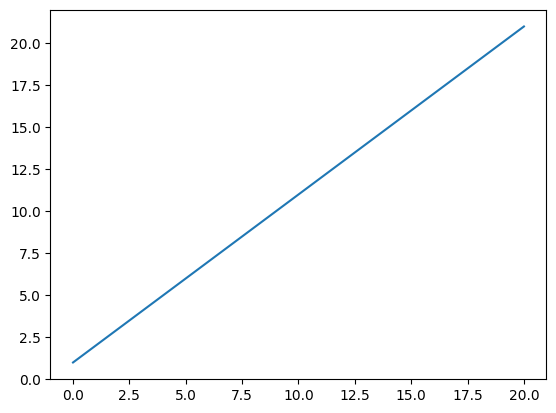

In [34]:
a = 1
b = 1
build_linear_dependency(a, b)

Якщо ж
`a = 1`
`b = 5`

Отже:

`y = 1*x + 5 = x + 5`

Кут нахилу той самий, але зміщення за віссю ОУ інше.

[ 0.          2.22222222  4.44444444  6.66666667  8.88888889 11.11111111
 13.33333333 15.55555556 17.77777778 20.        ] [ 5.          7.22222222  9.44444444 11.66666667 13.88888889 16.11111111
 18.33333333 20.55555556 22.77777778 25.        ]


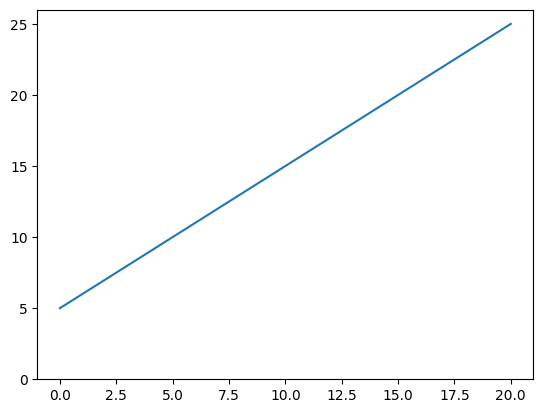

In [35]:
a = 1
b = 5
build_linear_dependency(a, b);

Якщо ж
`a = 2`
`b = 5`

Отже:

`y = 2*x + 5`

Зміщення за віссю ОУ таке саме, але кут інший.

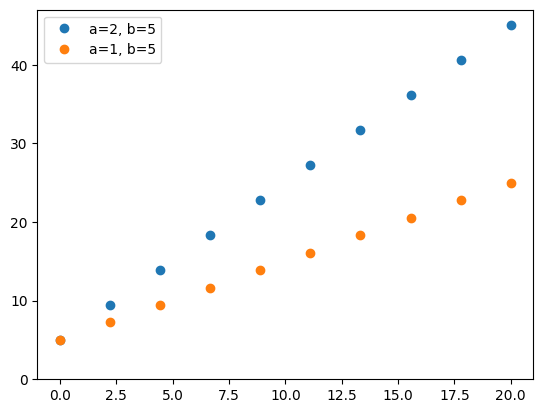

In [36]:
xs = np.linspace(0,20,10)

a, b = 2, 5
y = xs * a + b
plt.plot(xs , y, 'o', label=f'a={a}, b={b}')
a, b = 1, 5
y = xs * a + b
plt.plot(xs , y, 'o', label=f'a={a}, b={b}')
plt.ylim(ymin=0)
plt.legend();

Тож, за існуючих значень а і b ми завжди можемо побудувати лінію на площині (де є два виміри).

---------

Вертаємось до нашої задачі.


Ми вже знаємо, що стовпці "курець" та "вік" мають найсильнішу кореляцію з "зборами". Спробуємо знайти спосіб оцінки значення "зборів" за допомогою значення "віку" для некурців. Спочатку створимо фрейм даних, який містить лише дані для некурців.

In [37]:
non_smoker_df = medical_df[medical_df.smoker == 'no']

Далі, давайте візуалізуємо взаємозв'язок між "віком" та "зборами"

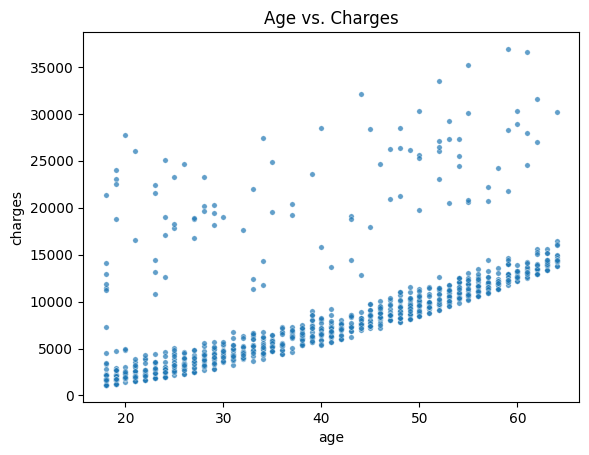

In [38]:
plt.title('Age vs. Charges')
sns.scatterplot(data=non_smoker_df, x='age', y='charges', alpha=0.7, s=15);

Окрім декількох винятків, точки, здається, формують лінію.

 Ми спробуємо "підібрати" лінію, використовуючи ці точки, і використовувати лінію для прогнозування вартості за віком. Лінія на координатах X&Y має  формулу як ви вже згадали:

  $y = wx + b$

  В машинному навчання тільки "нахил" позначається $w$, а "зміщення" позначається $b$.

### Модель

У вищенаведеному випадку вісь x показує "вік", а вісь y показує "збори". Таким чином, ми припускаємо наступну залежність між ними:

$charges = w \times age + b$

Ми спробуємо визначити $w$ і $b$ для лінії, яка найкраще підходить для даних.

* Цей метод називається _лінійною регресією_, і ми називаємо вищенаведене рівняння _моделлю лінійної регресії_, оскільки воно моделює залежність між "віком" і "вартістю" як пряму лінію.

* Числа $w$ і $b$ називаються _параметрами_ або _вагами_ моделі.

* Значення в стовпці "вік" набору даних називаються _вхідними даними_ моделі, а значення в стовпці "збори" називаються "таргетом" (ціллю).

Давайте визначимо допоміжну функцію `estimate_charges`, щоб обчислити $charges$, з урахуванням $age$, $w$ і $b$.

In [39]:
def estimate_charges(age, w, b):
    return w * age + b

Функція `estimate_charges` є нашою першою _моделлю_.

Давайте _здогадаємося_ щодо значень для $w$ та $b$ і використаємо їх для оцінки вартості послуг.

In [40]:
w = 50
b = 100

In [41]:
ages = non_smoker_df.age
estimated_charges = estimate_charges(ages, w, b)

Ми можемо відобразити оцінені збори за допомогою лінійного графіка.

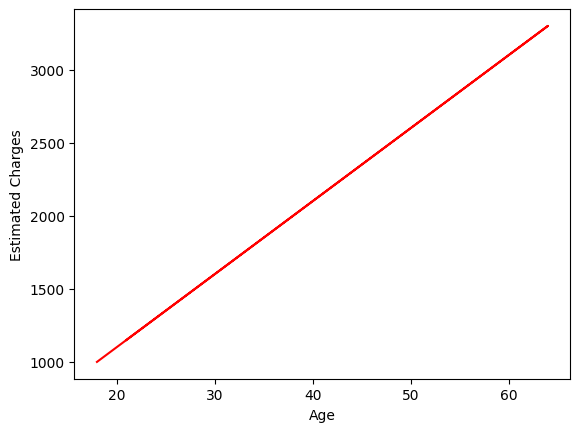

In [42]:
plt.plot(ages, estimated_charges, 'r');
plt.xlabel('Age');
plt.ylabel('Estimated Charges');

Як і очікувалося, точки лежать на прямій лінії.

Ми можемо накласти цю лінію на реальні дані, щоб побачити, наскільки добре наша _модель_ відповідає _даним_.

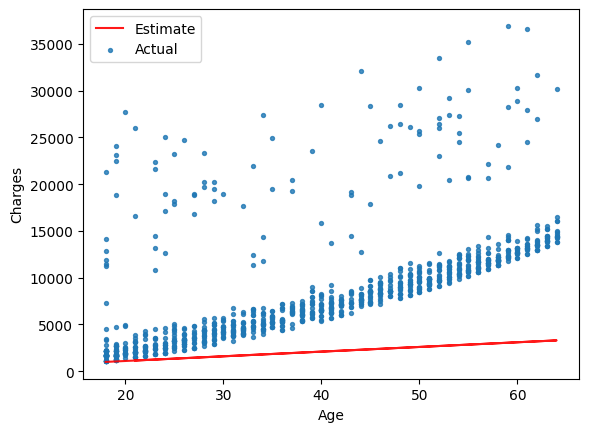

In [43]:
target = non_smoker_df.charges

plt.plot(ages, estimated_charges, 'r', alpha=0.9);
plt.scatter(ages, target, s=8,alpha=0.8);
plt.xlabel('Age');
plt.ylabel('Charges')
plt.legend(['Estimate', 'Actual']);

Очевидно, наші оцінки досить погані, і лінія не "підходить" до даних. Однак, ми можемо спробувати різні значення $w$ та $b$, щоб перемістити лінію. Давайте визначимо допоміжну функцію `try_parameters`, яка приймає `w` та `b` як вхідні дані та створює вищезазначений графік.

In [44]:
def try_parameters(w, b):
    ages = non_smoker_df.age
    target = non_smoker_df.charges

    estimated_charges = estimate_charges(ages, w, b)

    plt.plot(ages, estimated_charges, 'r', alpha=0.9);
    plt.scatter(ages, target, s=8,alpha=0.8);
    plt.xlabel('Age');
    plt.ylabel('Charges')
    plt.legend(['Estimate', 'Actual']);

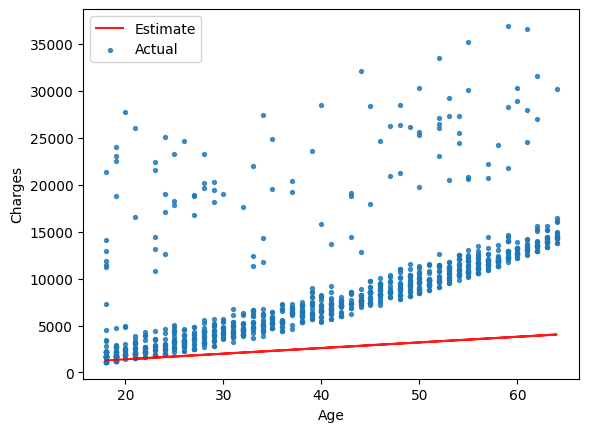

In [45]:
try_parameters(60, 200)

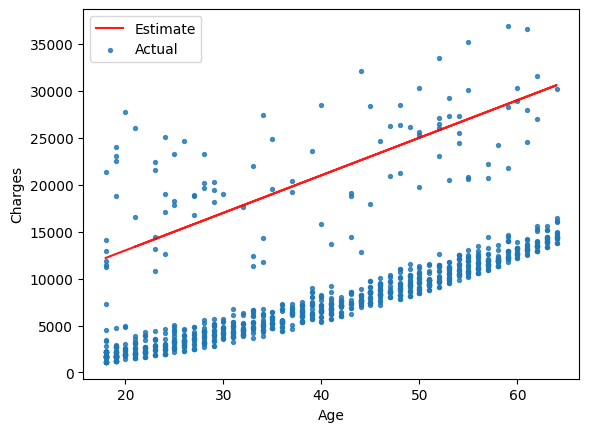

In [46]:
try_parameters(400, 5000)

Коли ми змінюємо значення $w$ та $b$ вручну, намагаючись візуально наблизити лінію до точок, ми _вчимося_ приблизному відношенню між "віком" та "зборами".

Чи не було б чудово, якби комп'ютер міг спробувати кілька різних значень `w` та `b` та _вивчити_ відношення між "віком" та "зборами"? Щоб зробити це, нам потрібно вирішити кілька проблем:

1. Нам потрібен спосіб числово виміряти, наскільки добре лінія підходить до точок.

2. Після того, як "міра відповідності" була обчислена, нам потрібен спосіб змінити (оновити) `w` та `b`, щоб покращити відповідність (або "підгонку моделі").

Якщо ми зможемо вирішити вищезазначені проблеми, комп'ютер повинен мати змогу визначити `w` та `b` для лінії найкращої відповідності, починаючи з випадкового припущення (як ми з вами зробили спочатку).

### Функція втрат/вартості

Ми можемо порівняти прогнози нашої моделі з фактичними цілями за допомогою наступного методу:

* Розрахувати різницю між цілями та прогнозами (ця різниця називається "залишком")
* Піднести до квадрату всі елементи матриці різниць, щоб усунути від'ємні значення.
* Розрахувати середнє значення елементів у результуючій матриці.
* Взяти квадратний корінь з результату

Результатом є одне число, відоме як **коренева середньоквадратична помилка** (RMSE). Вищенаведений опис можна виразити математично наступним чином:

<img src="https://i.imgur.com/WCanPkA.png" width="360">

Геометрично, залишки можна візуалізувати наступним чином:

<img src="https://i.imgur.com/ll3NL80.png" width="420">

Давайте визначимо функцію для обчислення RMSE.

In [47]:
def rmse(targets, predictions):
    return np.sqrt(np.mean(np.square(targets - predictions)))

Давайте обчислимо RMSE для нашої моделі з набором вибіркових ваг

In [48]:
w = 50
b = 100

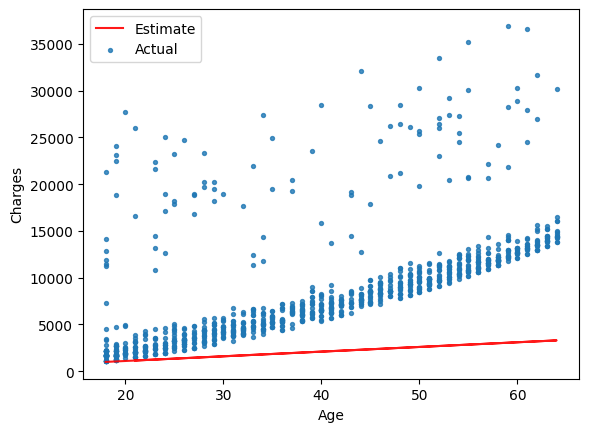

In [49]:
try_parameters(w, b)

In [50]:
targets = non_smoker_df['charges']
predicted = estimate_charges(non_smoker_df.age, w, b)

In [51]:
rmse(targets, predicted)

np.float64(8461.949562575493)

In [52]:
medical_df.charges.describe()

,charges
count,1338.000000
mean,13270.422265
std,12110.011237
min,1121.873900
25%,4740.287150
50%,9382.033000
75%,16639.912515
max,63770.428010


Ось як ми можемо **інтерпретувати** вищезазначене число: *В середньому, кожен елемент у прогнозі відрізняється від фактичної цілі на \$8461*.

Результат називається **втратою** (eng. loss), оскільки він вказує на те, наскільки погано модель прогнозує цільові змінні. Він представляє втрату інформації побудованою моделлю: *чим нижче втрата, тим краща модель*.

Давайте змінимо функції `try_parameters`, щоб також відображати втрату.

In [53]:
def try_parameters(w, b):
    ages = non_smoker_df.age
    target = non_smoker_df.charges
    predictions = estimate_charges(ages, w, b)

    plt.plot(ages, predictions, 'r', alpha=0.9);
    plt.scatter(ages, target, s=8,alpha=0.8);
    plt.xlabel('Age');
    plt.ylabel('Charges')
    plt.legend(['Prediction', 'Actual']);

    loss = rmse(target, predictions)
    print("RMSE Loss: ", loss)

RMSE Loss:  8461.949562575493


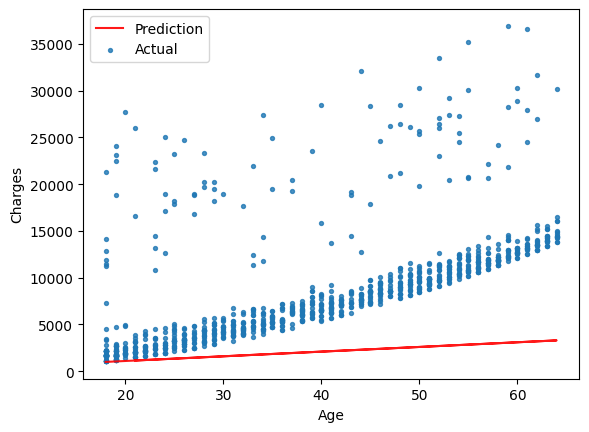

In [54]:
try_parameters(50, 100)

### Оптимізатор

Далі нам потрібна стратегія зміни ваг `w` та `b` для зменшення втрат і поліпшення "підгонки" лінії до даних. Для цього існує метод найменших квадратів та градієнтний спуск.



* Метод найменших квадратів (краще для менших наборів даних)


* Градієнтний спуск: (краще для більших наборів даних)


Обидва ці методи мають однакову мету: мінімізувати втрати, однак, метод найменших квадратів безпосередньо обчислює найкращі значення для `w` та `b`, використовуючи операції з матрицями, тоді як градієнтний спуск використовує ітеративний підхід, починаючи з випадкових значень `w` та `b` і поступово поліпшуючи їх за допомогою похідних.

Ось візуалізація того, як працює градієнтний спуск:

![](https://miro.medium.com/max/1728/1*NO-YvpHHadk5lLxtg4Gfrw.gif)

Чи не схоже це на нашу власну стратегію поступового наближення лінії до точок?